In [173]:
from PIL import Image
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import random

In [182]:
import tensorflow, keras
print('Tensorflow version: '+ tensorflow.__version__ + '\n' + 'Keras version: '+ keras.__version__)
import keras
from keras.models import Sequential, Input, Model
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Tensorflow version: 1.5.1
Keras version: 2.1.6


## Functions

In [2]:
def PIL_resize(path_to_image, resize_to=(200, 200), quality_=100, 
               img_show = False, img_save=True, show_from_file=False):
    im = Image.open(path_to_image) # read image
    f, e = os.path.splitext(path_to_image) # split image path to path and .jpg
    im_resize = im.resize(resize_to, Image.ANTIALIAS) # resize image
    if (img_save & ~(show_from_file)):
        im_resize.save(f + '.jpg', 'JPEG', quality=quality_) # save image
    if img_show:
        display(im_resize)
    if show_from_file:
        im_resize.save(f + 'temp.jpg', 'JPEG', quality=quality_)
        imshow(np.asarray(Image.open(f + 'temp.jpg')))
        os.remove(f + 'temp.jpg')
    if (img_save & show_from_file):
        print('To overwrite the file select img_save=True & show_from_file=False')

## Get paths

In [4]:
paths = "/home/chrysa/google_photos/pictures/"
dirs = os.listdir(paths)
paths = [paths + fl + '/' for fl in dirs if fl[0] != "."]

## Get img sizes and paths

In [6]:
%%capture

sizes = defaultdict(list)
imgs = defaultdict(list)
for path in paths:
    pics = os.listdir(path)
    for pic in pics:
        try:
            sizes[path.split('/')[-2]].append(Image.open(path+pic).size)
            imgs[path.split('/')[-2]].append(path+pic)
        except:
            pass

## Plot the aspect ratio

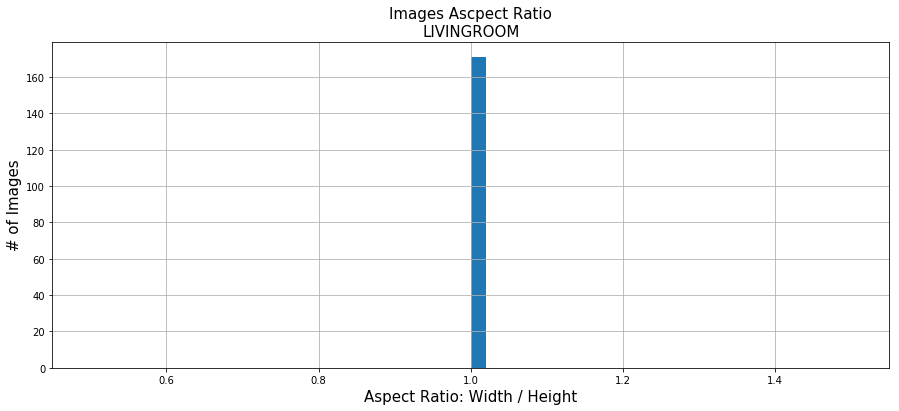

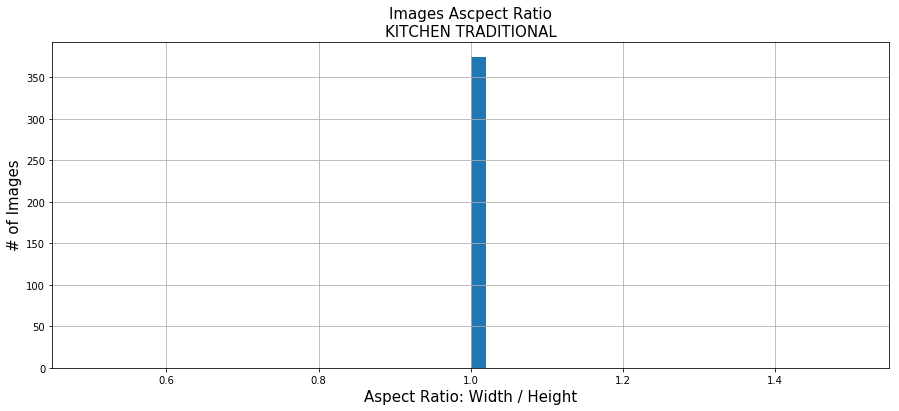

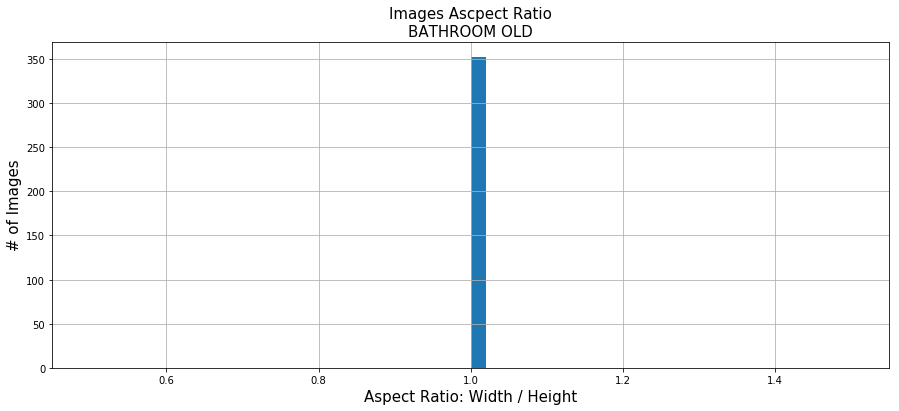

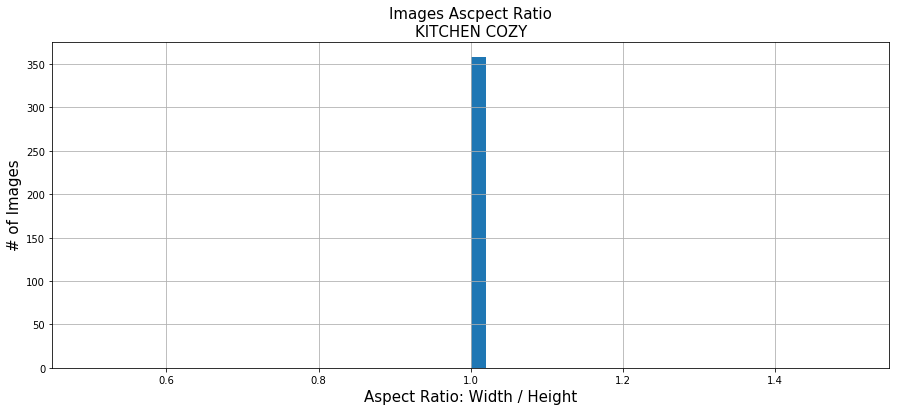

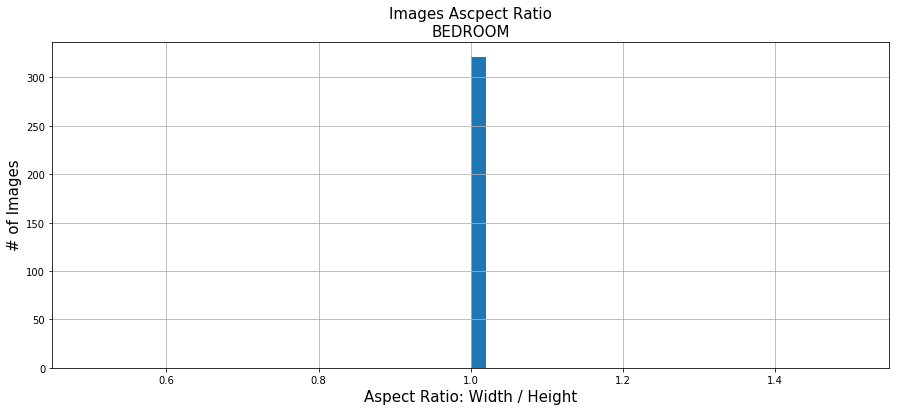

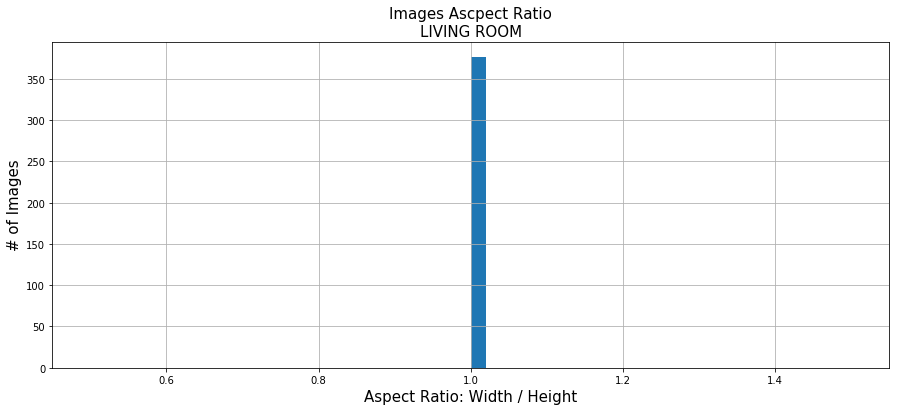

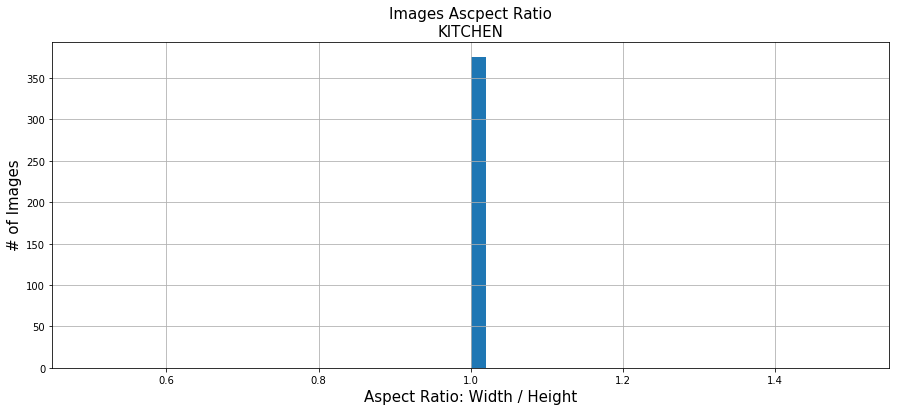

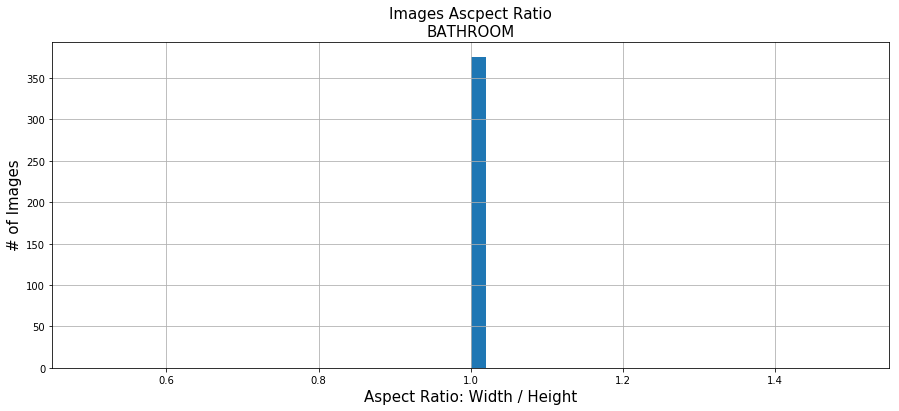

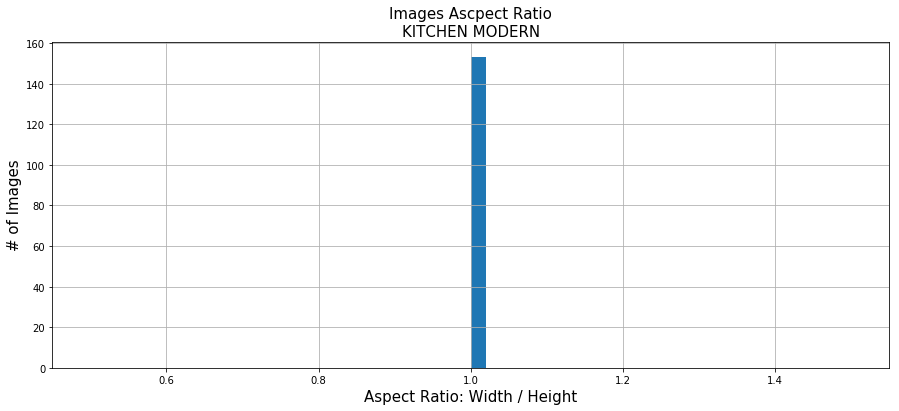

In [6]:
for k, v in sizes.items():
    df_tmp = pd.DataFrame(sizes[k], columns=['width', 'height'])
    plt.figure()
    (df_tmp.width / df_tmp.height).hist(bins = 50, figsize=(15, 6))
    plt.xlabel('Aspect Ratio: Width / Height', fontsize=15)
    plt.ylabel('# of Images', fontsize=15)
    plt.title('Images Ascpect Ratio\n' + k.upper(), fontsize=15)

## Resizing images

In [6]:
removed_imgs = defaultdict(int)
for k, pic_urls in imgs.items():
    print('-- Running for: ' + str(k))
    for i, pic_url in enumerate(pic_urls):
        if not(i % 50):
            print('-- resized: ' + str(i) + ' of ' + str(len(pic_urls)))
        try:
            PIL_resize(path_to_image=pic_url, resize_to=(100,100), quality_=100, 
                       img_show=False, img_save=True, show_from_file=False)
        except:
            removed_imgs[k] += 1
            os.remove(pic_url)

-- Running for: livingroom
-- resized: 0 of 171
-- resized: 50 of 171
-- resized: 100 of 171
-- resized: 150 of 171
-- Running for: kitchen traditional
-- resized: 0 of 374
-- resized: 50 of 374
-- resized: 100 of 374
-- resized: 150 of 374
-- resized: 200 of 374
-- resized: 250 of 374
-- resized: 300 of 374
-- resized: 350 of 374
-- Running for: bathroom old
-- resized: 0 of 352
-- resized: 50 of 352
-- resized: 100 of 352
-- resized: 150 of 352
-- resized: 200 of 352
-- resized: 250 of 352
-- resized: 300 of 352
-- resized: 350 of 352
-- Running for: kitchen cozy
-- resized: 0 of 358
-- resized: 50 of 358
-- resized: 100 of 358
-- resized: 150 of 358
-- resized: 200 of 358
-- resized: 250 of 358
-- resized: 300 of 358
-- resized: 350 of 358
-- Running for: bedroom
-- resized: 0 of 321
-- resized: 50 of 321
-- resized: 100 of 321
-- resized: 150 of 321
-- resized: 200 of 321
-- resized: 250 of 321
-- resized: 300 of 321
-- Running for: living room
-- resized: 0 of 376
-- resized: 50 o

In [7]:
removed_imgs

defaultdict(int, {})

## View image

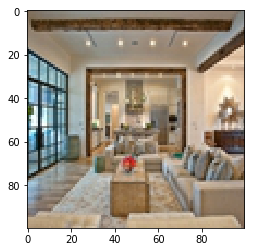

In [7]:
imshow(np.asarray(Image.open(imgs['livingroom'][120])));

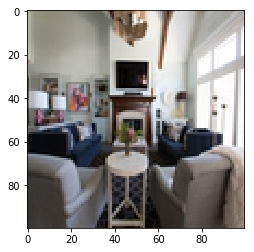

In [9]:
PIL_resize(path_to_image=imgs['livingroom'][10], resize_to=(100,100), quality_=100, 
                       img_show=False, img_save=False, show_from_file=True)

### Reshape images

<img src='https://preview.ibb.co/f1rvxy/reshape_img.jpg'>

<b>Min - Max Normalize </b><br>
$z_i=\cfrac{x_i-\min(x)}{\max(x)-\min(x)}$ for `RBG` its $z_i=\cfrac{x_i-0}{255-0} \Rightarrow z_i=\cfrac{x_i}{255}$

In [8]:
# Get number of images
imgs_count = 0
for k in imgs.keys():
    imgs_count += len(imgs[k])

In [9]:
### How many pixels / RGB do we have per image
img = np.asarray(Image.open(imgs[k][0]))
img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2], 1)
img.shape[0]

30000

In [10]:
### howmany images
imgs_count

2855

In [11]:
### initial matrix X of dimantions n, m where n is the number of pixels * rgb colours and m are the number of images
X = np.zeros((img.shape[0], imgs_count))
### I am going to store the labeled data of the image in Y
Y = list()

In [12]:
### For every image we have stored create respective X and Y
i = 0
### k is the folder where we have the image stored
### pic_urls are the paths of the images we have in the k folder
for k, pic_urls in imgs.items():
    print('-- Running for: ' + str(k))
    ### for every image 
    for pic_url in pic_urls:
        ### open the image
        img = np.asarray(Image.open(pic_url))
        ### convert the image to a vector of size x_pixels * y_pixels * 3, 1 and store it
        ### in the respective column of matrix X. 
        ### For example the first imgae in going to be stored in the first column of X
        X[:, i] = img.reshape(img.shape[0] * img.shape[1] * img.shape[2]) / 255
        ### append the folder name in which the image was saved
        Y.append(k)
        i += 1

-- Running for: livingroom
-- Running for: kitchen traditional
-- Running for: bathroom old
-- Running for: kitchen cozy
-- Running for: bedroom
-- Running for: living room
-- Running for: kitchen
-- Running for: bathroom
-- Running for: kitchen modern


In [13]:
### Recode Y
map_Y = {
 'bathroom':'bathroom',
 'bathroom old':'bathroom',
 'bedroom':'bedroom',
 'kitchen':'kitchen',
 'kitchen cozy':'kitchen',
 'kitchen modern':'kitchen',
 'kitchen traditional':'kitchen',
 'living room':'livingroom',
 'livingroom':'livingroom'}
Y = [map_Y[el] for el in Y]

In [14]:
set(Y)

{'bathroom', 'bedroom', 'kitchen', 'livingroom'}

### Save X and Y

In [15]:
np.save('X', X)
np.save('Y', Y)

### Load X and Y

In [7]:
X = np.load('X.npy')
Y = np.load('Y.npy')

### Logistic Regressions

You will first test a <b>Logistic Regression</b> activation function, using a Neural Network mindset.<br>
<img src='https://preview.ibb.co/dAoscy/logistic_reg.jpg' style='width: 2px;'/>

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
Steps we will follow: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse results

#### Helper functions

**Sigmoid**: $sigmoid( w^T x + b) = \cfrac{1}{1 + e^{-(w^T x + b)}}$

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

**Initializing parameters:** You will initialize `w` as a vector of zeros.

In [6]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(dim).reshape(dim, 1)
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

**Forward and Backward propagation** We use the following cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

In [7]:
def propagate(w, b, X, Y):
    """
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-kitchen, 1 if kitchen) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)                                # compute activation
    cost = - 1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))                                 # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

**Optimization:** Our goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db

        
        # Record the costs
        if i % 500 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

**Predicting** Predicting the outcome

In [9]:
def predict(w, b, X, threshold=0.5):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = (A[0, i] > threshold) * 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

**Merging all functions into a model**

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the helper functions
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations = num_iterations, 
                                        learning_rate = learning_rate, print_cost = print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors/confusion metrics
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    print('Precision: is acuracy of possitive predictions')
    print('Recall: fraction of positives that where correctly identified')
    print(metrics.classification_report(Y_test[0], Y_prediction_test.astype(int)[0]))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### Running Logistic regression model

### Kitchen

In [85]:
# Recode Y to 0 and 1
room = 'kitchen'
Y_ = [(rm == room)*1 for rm in Y]

### Split training and test set

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [87]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [88]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1912)
y_train:  (1, 1912)
Train Rooms:  0.44142259414225943
X_test:  (30000, 943)
y_test:  (1, 943)
Test Rooms:  0.4411452810180276


In [89]:
kitchen = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.723907
Cost after iteration 1000: 0.674015
Cost after iteration 1500: 0.637820
Cost after iteration 2000: 0.606427
Cost after iteration 2500: 0.578090
Cost after iteration 3000: 0.552096
Cost after iteration 3500: 0.528014
Cost after iteration 4000: 0.505535
Cost after iteration 4500: 0.484441
Cost after iteration 5000: 0.464638
Cost after iteration 5500: 0.446975
Cost after iteration 6000: 0.436451
Cost after iteration 6500: 0.428330
Cost after iteration 7000: 0.420610
Cost after iteration 7500: 0.413253
Cost after iteration 8000: 0.406225
Cost after iteration 8500: 0.399500
Cost after iteration 9000: 0.393052
Cost after iteration 9500: 0.386861
train accuracy: 87.5 %
test accuracy: 62.88441145281018 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.65      0.73      0.69       527
          

### Bedroom

In [90]:
# Recode Y to 0 and 1
room = 'bedroom'
Y_ = [(rm == room)*1 for rm in Y]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [92]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [93]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1912)
y_train:  (1, 1912)
Train Rooms:  0.1087866108786611
X_test:  (30000, 943)
y_test:  (1, 943)
Test Rooms:  0.11983032873807


In [94]:
bedroom = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.281129
Cost after iteration 1000: 0.262543
Cost after iteration 1500: 0.250294
Cost after iteration 2000: 0.240420
Cost after iteration 2500: 0.231887
Cost after iteration 3000: 0.224271
Cost after iteration 3500: 0.217347
Cost after iteration 4000: 0.210976
Cost after iteration 4500: 0.205063
Cost after iteration 5000: 0.199540
Cost after iteration 5500: 0.194355
Cost after iteration 6000: 0.189467
Cost after iteration 6500: 0.184846
Cost after iteration 7000: 0.180463
Cost after iteration 7500: 0.176298
Cost after iteration 8000: 0.172330
Cost after iteration 8500: 0.168543
Cost after iteration 9000: 0.164925
Cost after iteration 9500: 0.161460
train accuracy: 94.50836820083683 %
test accuracy: 89.5015906680806 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.91      0.98      0.94       83

### Bathroom

In [96]:
# Recode Y to 0 and 1
room = 'bathroom'
Y_ = [(rm == room)*1 for rm in Y]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [98]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [99]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1912)
y_train:  (1, 1912)
Train Rooms:  0.2630753138075314
X_test:  (30000, 943)
y_test:  (1, 943)
Test Rooms:  0.23753976670201485


In [100]:
bathroom = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.512715
Cost after iteration 1000: 0.491225
Cost after iteration 1500: 0.474496
Cost after iteration 2000: 0.460345
Cost after iteration 2500: 0.447957
Cost after iteration 3000: 0.436879
Cost after iteration 3500: 0.426825
Cost after iteration 4000: 0.417596
Cost after iteration 4500: 0.409049
Cost after iteration 5000: 0.401080
Cost after iteration 5500: 0.393606
Cost after iteration 6000: 0.386562
Cost after iteration 6500: 0.379896
Cost after iteration 7000: 0.373567
Cost after iteration 7500: 0.367540
Cost after iteration 8000: 0.361784
Cost after iteration 8500: 0.356276
Cost after iteration 9000: 0.350993
Cost after iteration 9500: 0.345918
train accuracy: 87.918410041841 %
test accuracy: 73.38282078472959 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.80      0.87      0.83       719

### Living Room

In [12]:
# Recode Y to 0 and 1
room = 'livingroom'
Y_ = [(rm == room)*1 for rm in Y]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [14]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [15]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1912)
y_train:  (1, 1912)
Train Rooms:  0.18671548117154813
X_test:  (30000, 943)
y_test:  (1, 943)
Test Rooms:  0.2014846235418876


In [16]:
livingroom = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.413209
Cost after iteration 1000: 0.390284
Cost after iteration 1500: 0.372173
Cost after iteration 2000: 0.356874
Cost after iteration 2500: 0.343538
Cost after iteration 3000: 0.331676
Cost after iteration 3500: 0.320970
Cost after iteration 4000: 0.311201
Cost after iteration 4500: 0.302208
Cost after iteration 5000: 0.293871
Cost after iteration 5500: 0.286095
Cost after iteration 6000: 0.278809
Cost after iteration 6500: 0.271953
Cost after iteration 7000: 0.265479
Cost after iteration 7500: 0.259348
Cost after iteration 8000: 0.253525
Cost after iteration 8500: 0.247984
Cost after iteration 9000: 0.242699
Cost after iteration 9500: 0.237649
train accuracy: 92.05020920502092 %
test accuracy: 79.2152704135737 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.83      0.93      0.88       75

## With hidden layers

We will have one hidden layers with 5 neurans. <br> - The activation function for the hidden layer will be $tanh$. <br> - Tha activation function for the output will again be a $signmoid$

#### Helper functions

In [18]:
def layer_sizes(X, Y, n_h=5):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = n_h
    n_y = Y.shape[0] # size of output layer

    return (n_x, n_h, n_y)

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y)
    cost = -(1/m) * np.sum(logprobs) 
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate= 0.001, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x=n_x, n_h=n_h, n_y=n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X=X, parameters=parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2=A2, Y=Y, parameters=parameters)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters=parameters, cache=cache, X=X, Y=Y)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters=parameters, grads=grads, learning_rate = learning_rate)
        
        # Print the cost every 500 iterations
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

def predict(parameters, X_train, Y_train, X_test, Y_test, threeshold=0.5):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    Y -- actual, labeled
    threeshold -- cut of of sigmoid
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X=X_test, parameters=parameters)
    predictions = (A2 > threeshold) * 1
       
    # Print train/test Errors/confusion metrics
    print("train accuracy: {} %".format(100 - \
            np.mean(np.abs((forward_propagation(X=X_train, parameters=parameters)[0] > threeshold) - \
                           Y_train[0])) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(predictions[0] - Y_test)) * 100))
    print('Precision: is acuracy of possitive predictions')
    print('Recall: fraction of positives that where correctly identified')
    print(metrics.classification_report(Y_test[0], predictions[0]))
    
    return predictions

### Kitchen 2

In [42]:
# Recode Y to 0 and 1
room = 'kitchen'
Y_ = [(rm == room)*1 for rm in Y]

#### Split training and test set

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [44]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [45]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1912)
y_train:  (1, 1912)
Train Rooms:  0.4304393305439331
X_test:  (30000, 943)
y_test:  (1, 943)
Test Rooms:  0.4634146341463415


In [24]:
kitchen = nn_model(X=X_train, Y=y_train, n_h = 5, num_iterations = 10000, learning_rate = 0.001)

In [50]:
_ = predict(parameters=kitchen, X_train=X_train, Y_train=y_train, 
                     X_test=X_test, Y_test=y_test, threeshold=0.45)

train accuracy: 79.96861924686192 %
test accuracy: 61.6118769883351 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.63      0.70      0.66       506
          1       0.60      0.51      0.55       437

avg / total       0.61      0.62      0.61       943



### Convolution Neural networks

Based on the <a href="https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python">blog post</a>

<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/Typical_cnn_kecdep.png">

Subsampling helps in reducing overfiting
<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/max-pooling_tkk5n2.png">

### Importing the data

We will convert each image into greyscale of size 100 x 100 and then into a matrix of size 100 x 100 x 1 which is fed into the network.

In [8]:
samples = X.shape[1] # how many images do we have

In [88]:
### initial matrix X of dimantions n, m where n is the number of pixels * rgb colours and m are the number of images
X = np.full((samples, 100, 100, 1),0.0)
### I am going to store the labeled data of the image in Y
Y = list()

In [89]:
### For every image we have stored create respective X and Y
i = 0
### k is the folder where we have the image stored
### pic_urls are the paths of the images we have in the k folder
for k, pic_urls in imgs.items():
    print('-- Running for: ' + str(k))
    ### for every image 
    for pic_url in pic_urls:
        ### open the image and reshape to 100 X 100 X 1
        img = np.asarray(Image.open(pic_url).convert('L')).reshape(100, 100, 1)
        ### For example the first imgae in going to be stored in the first column of X
        X[i] = img / 255.0
        ### append the folder name in which the image was saved
        Y.append(k)
        i += 1

-- Running for: livingroom
-- Running for: kitchen traditional
-- Running for: bathroom old
-- Running for: kitchen cozy
-- Running for: bedroom
-- Running for: living room
-- Running for: kitchen
-- Running for: bathroom
-- Running for: kitchen modern


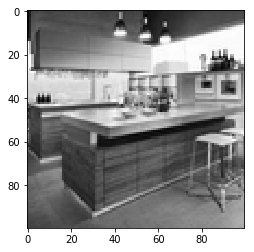

In [73]:
# greyscale image
imshow(Image.open(pic_url).convert('LA'));

In [94]:
## Check that X is populated
X[99][:2, 0]

array([[0.94901961],
       [0.95294118]])

In [95]:
### Recode Y
map_Y = {
 'bathroom':'bathroom',
 'bathroom old':'bathroom',
 'bedroom':'bedroom',
 'kitchen':'kitchen',
 'kitchen cozy':'kitchen',
 'kitchen modern':'kitchen',
 'kitchen traditional':'kitchen',
 'living room':'livingroom',
 'livingroom':'livingroom'}
Y = [map_Y[el] for el in Y]

In [96]:
### Recode Y
map_Y = {
 'bathroom': 0,
 'bedroom': 1,
 'kitchen': 2,
 'livingroom': 3
}
Y_ = [map_Y[el] for el in Y]

In [97]:
classes = np.unique(Y_)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  4
Output classes :  [0 1 2 3]


In [98]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y_, test_size=0.15, random_state=42)
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)
print('train_X: ' + str(train_X.shape))
print('train_Y: ' + str(train_Y.shape))
print('test_X: ' + str(test_X.shape))
print('test_Y: ' + str(test_Y.shape))

train_X: (2426, 100, 100, 1)
train_Y: (2426,)
test_X: (429, 100, 100, 1)
test_Y: (429,)


In [99]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [100]:
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0.]


For the train further split to <code>train</code> and <code>validate</code>

In [101]:
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                           test_size=0.2, random_state=13)

In [102]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((1940, 100, 100, 1), (486, 100, 100, 1), (1940, 4), (486, 4))

We will use three convolutional layers: <br>

* The first layer will have 32-3 x 3 filters,
* The second layer will have 64-3 x 3 filters and
* The third layer will have 128-3 x 3 filters.<br>

<font color="red">In addition, there are three max-pooling layers each of size 2 x 2. </font>

<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/fashion-mnist-architecture_htbpsz.png">

In [103]:
batch_size = 64
epochs = 10
num_classes = nClasses

We will be using the `Leaky ReLU` as the activation function

<img src="https://cdn-images-1.medium.com/max/1600/1*LXlJ4zDmYGg9yymgFzyOdA.png">

In [104]:
img_model = Sequential()
img_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear',
                     input_shape=(100, 100 , 1), padding='same'))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D((2, 2),padding='same'))
img_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.01))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Flatten())
img_model.add(Dense(128, activation='linear'))
img_model.add(LeakyReLU(alpha=0.01))
img_model.add(Dense(num_classes, activation='softmax'))

### Compiling the Model

In [105]:
img_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [106]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 128)       73856     
__________

### Training the Model

In [107]:
img_train = img_model.fit(train_X, train_label, batch_size=batch_size,
                          epochs=epochs,verbose=1,
                          validation_data=(valid_X, valid_label))

Train on 1940 samples, validate on 486 samples
Epoch 1/10
1940/1940 [==============================] - 29s 15ms/step - loss: 1.2996 - acc: 0.4392 - val_loss: 1.1478 - val_acc: 0.5041
Epoch 2/10
1940/1940 [==============================] - 28s 15ms/step - loss: 1.0731 - acc: 0.5531 - val_loss: 0.9700 - val_acc: 0.6029
Epoch 3/10
1940/1940 [==============================] - 28s 15ms/step - loss: 0.8832 - acc: 0.6448 - val_loss: 0.9242 - val_acc: 0.6379
Epoch 4/10
1940/1940 [==============================] - 28s 15ms/step - loss: 0.7668 - acc: 0.7005 - val_loss: 0.9261 - val_acc: 0.6605
Epoch 5/10
1940/1940 [==============================] - 29s 15ms/step - loss: 0.6792 - acc: 0.7330 - val_loss: 0.8428 - val_acc: 0.7078
Epoch 6/10
1940/1940 [==============================] - 29s 15ms/step - loss: 0.5582 - acc: 0.7912 - val_loss: 0.9000 - val_acc: 0.6770
Epoch 7/10
1940/1940 [==============================] - 28s 15ms/step - loss: 0.4896 - acc: 0.8216 - val_loss: 0.9198 - val_acc: 0.6852
E

The model is overfitting, as the validation loss is 1.2048 and the validation accuracy is a meer 68.72%.<br> 
Overfitting gives an intuition that the network has memorized the training data very well but is not guaranteed to work on unseen data, and that is why there is a difference in the training and validation accuracy.

### Model Evaluation

In [108]:
test_eval = img_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [109]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1154791611335773
Test accuracy: 0.692307692724508


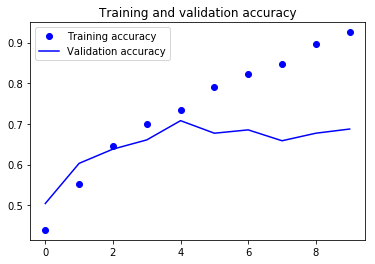

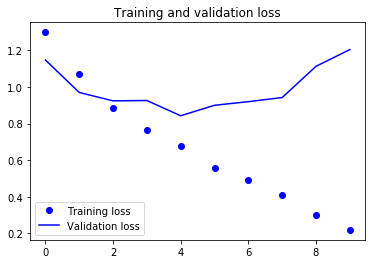

In [111]:
accuracy = img_train.history['acc']
val_accuracy = img_train.history['val_acc']
loss = img_train.history['loss']
val_loss = img_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, we can see that the validation accuracy almost became stagnant after 4-5 epochs and rarely increased at certain epochs.

The validation loss shows that this is the sign of overfitting, similar to validation accuracy it linearly decreased but after 4-5 epochs, it started to increase. This means that the model tried to memorize the data and succeeded.

With this in mind, it's time to introduce some dropout into our model and see if it helps in reducing overfitting.

### Adding Dropout into the Network

In [112]:
batch_size = 64
epochs = 10
num_classes = nClasses

In [113]:
img_model = Sequential()
img_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(100,100,1)))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D((2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.1))                  
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.4))
img_model.add(Flatten())
img_model.add(Dense(128, activation='linear'))
img_model.add(LeakyReLU(alpha=0.1))           
img_model.add(Dropout(0.3))
img_model.add(Dense(num_classes, activation='softmax'))

In [114]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
__________

In [115]:
img_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [116]:
img_train_dropout = img_model.fit(train_X, train_label, batch_size=batch_size,
                    epochs=epochs,verbose=1, validation_data=(valid_X, valid_label))

Train on 1940 samples, validate on 486 samples
Epoch 1/10
1940/1940 [==============================] - 31s 16ms/step - loss: 1.4918 - acc: 0.3897 - val_loss: 1.3018 - val_acc: 0.4938
Epoch 2/10
1940/1940 [==============================] - 30s 16ms/step - loss: 1.2727 - acc: 0.4381 - val_loss: 1.2683 - val_acc: 0.4300
Epoch 3/10
1940/1940 [==============================] - 30s 16ms/step - loss: 1.1520 - acc: 0.5026 - val_loss: 1.2956 - val_acc: 0.4362
Epoch 4/10
1940/1940 [==============================] - 31s 16ms/step - loss: 0.9692 - acc: 0.6057 - val_loss: 0.9158 - val_acc: 0.6235
Epoch 5/10
1940/1940 [==============================] - 30s 15ms/step - loss: 0.9073 - acc: 0.6263 - val_loss: 0.9262 - val_acc: 0.6111
Epoch 6/10
1940/1940 [==============================] - 30s 16ms/step - loss: 0.8281 - acc: 0.6649 - val_loss: 0.8593 - val_acc: 0.6440
Epoch 7/10
1940/1940 [==============================] - 30s 16ms/step - loss: 0.7156 - acc: 0.7160 - val_loss: 1.0394 - val_acc: 0.6481
E

In [117]:
test_eval = img_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [118]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.8087572636026324
Test accuracy: 0.6899766905324443


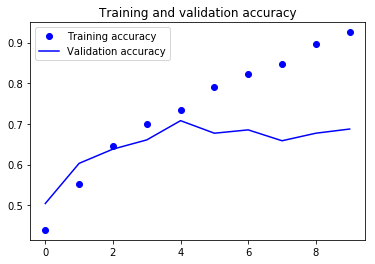

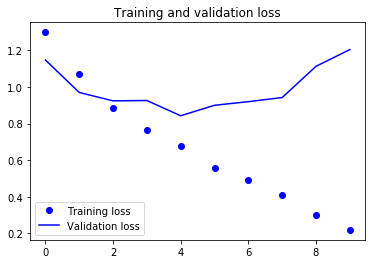

In [119]:
accuracy = img_train_dropout.history['acc']
val_accuracy = img_train_dropout.history['val_acc']
loss = img_train_dropout.history['loss']
val_loss = img_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predict Labels

In [120]:
predicted_classes = img_model.predict(test_X)

In [121]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [122]:
predicted_classes.shape, test_Y.shape

((429,), (429,))

* bathroom: 0
* bedroom: 1
* kitchen: 2
* livingroom: 3

Found 283 correct labels
65.967366 prcnt correct labels


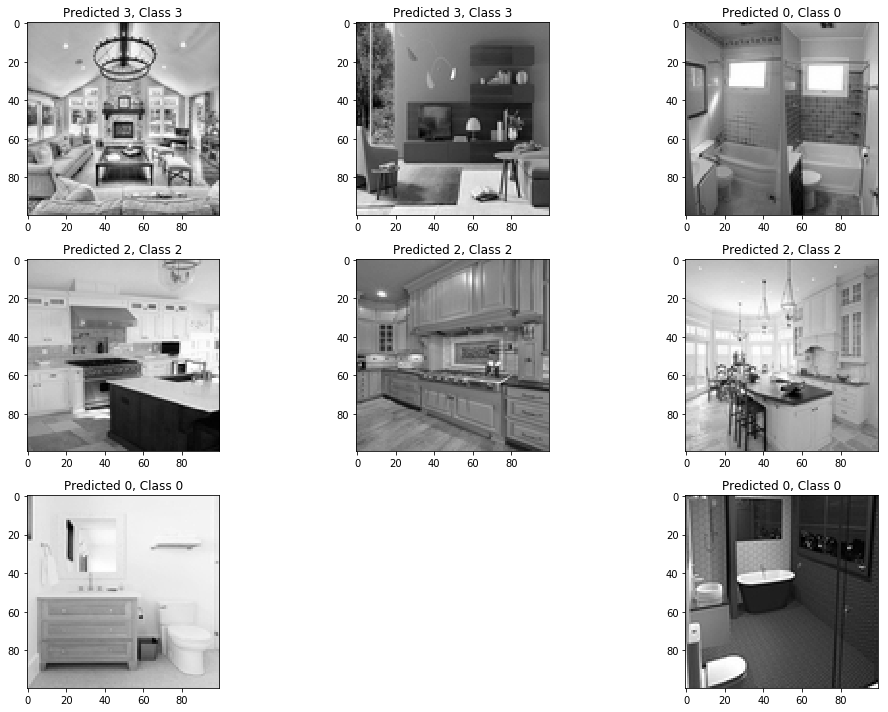

In [140]:
figure(figsize=(15, 10))
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
print("%f prcnt correct labels" % (len(correct) * 100 / len(test_Y)))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

* bathroom: 0
* bedroom: 1
* kitchen: 2
* livingroom: 3

Found 146 incorrect labels
34.032634 prcnt incorrect labels


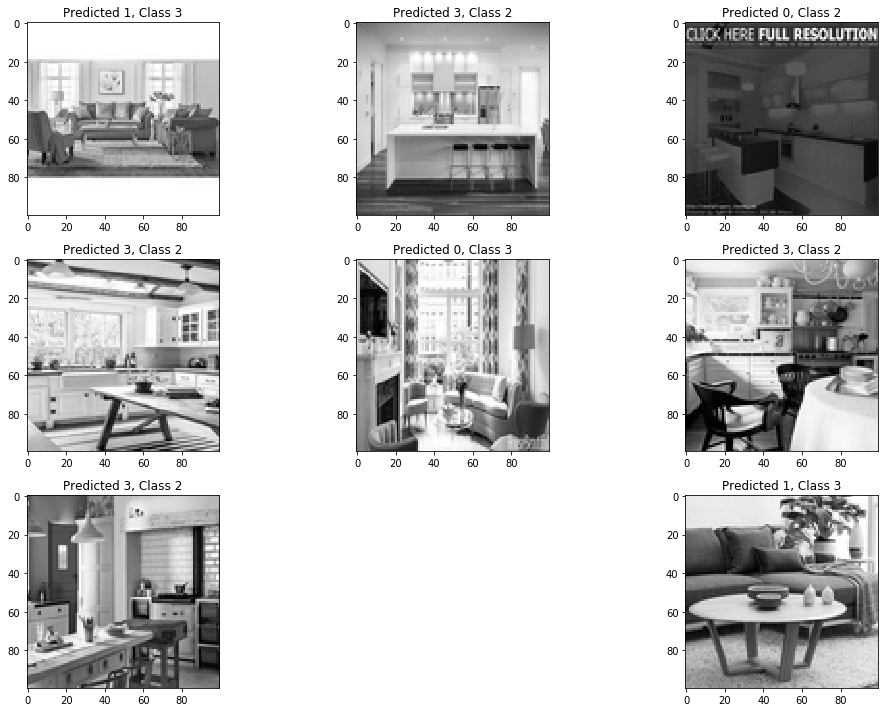

In [142]:
figure(figsize=(15, 10))
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
print("%f prcnt incorrect labels" % (len(incorrect) * 100 / len(test_Y)))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

### Classification Report

In [144]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.54      0.85      0.66       105
    Class 1       0.55      0.36      0.44        47
    Class 2       0.85      0.66      0.74       195
    Class 3       0.60      0.60      0.60        82

avg / total       0.69      0.66      0.66       429



### Adding Dropout into the Network, more apochs, smaller alpha

In [153]:
batch_size = 50
epochs = 33
num_classes = nClasses

In [154]:
img_model = Sequential()
img_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(100,100,1)))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D((2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.01))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.01))                  
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.4))
img_model.add(Flatten())
img_model.add(Dense(128, activation='linear'))
img_model.add(LeakyReLU(alpha=0.01))           
img_model.add(Dropout(0.3))
img_model.add(Dense(num_classes, activation='softmax'))

In [155]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 25, 25, 64)        0         
__________

In [156]:
### Complile
img_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [157]:
### Train model
img_train_dropout_100 = img_model.fit(train_X, train_label, batch_size=batch_size,
                    epochs=epochs,verbose=1, validation_data=(valid_X, valid_label))

Train on 1940 samples, validate on 486 samples
Epoch 1/33
1940/1940 [==============================] - 32s 16ms/step - loss: 1.3859 - acc: 0.3928 - val_loss: 1.3265 - val_acc: 0.4403
Epoch 2/33
1940/1940 [==============================] - 31s 16ms/step - loss: 1.2932 - acc: 0.4387 - val_loss: 1.3044 - val_acc: 0.4403
Epoch 3/33
1940/1940 [==============================] - 31s 16ms/step - loss: 1.2242 - acc: 0.4665 - val_loss: 1.0889 - val_acc: 0.5597
Epoch 4/33
1940/1940 [==============================] - 31s 16ms/step - loss: 1.0339 - acc: 0.5835 - val_loss: 0.9760 - val_acc: 0.5802
Epoch 5/33
1940/1940 [==============================] - 31s 16ms/step - loss: 0.9092 - acc: 0.6299 - val_loss: 0.8999 - val_acc: 0.6317
Epoch 6/33
1940/1940 [==============================] - 31s 16ms/step - loss: 0.8522 - acc: 0.6711 - val_loss: 0.9077 - val_acc: 0.6399
Epoch 7/33
1940/1940 [==============================] - 31s 16ms/step - loss: 0.7726 - acc: 0.7026 - val_loss: 0.8354 - val_acc: 0.6811
E

In [158]:
### Evaluate
test_eval_100 = img_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [159]:
print('Test loss:', test_eval_100[0])
print('Test accuracy:', test_eval_100[1])

Test loss: 1.24697960506786
Test accuracy: 0.7296037298816067


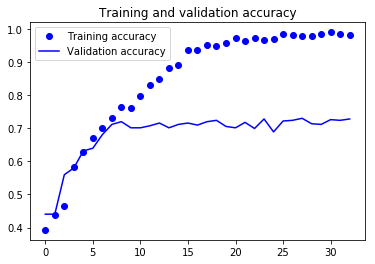

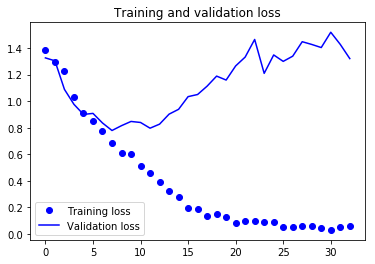

In [160]:
accuracy = img_train_dropout_100.history['acc']
val_accuracy = img_train_dropout_100.history['val_acc']
loss = img_train_dropout_100.history['loss']
val_loss = img_train_dropout_100.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [161]:
### Predicting labels
predicted_classes = img_model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_Y.shape

((429,), (429,))

* bathroom: 0
* bedroom: 1
* kitchen: 2
* livingroom: 3

Found 310 correct labels
72.261072 prcnt correct labels


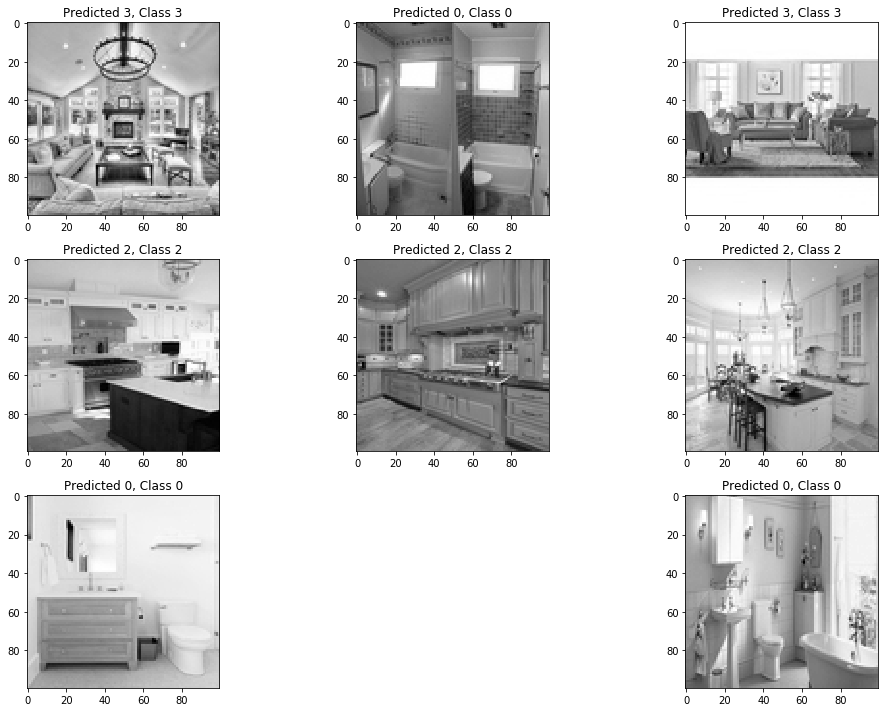

In [162]:
figure(figsize=(15, 10))
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
print("%f prcnt correct labels" % (len(correct) * 100 / len(test_Y)))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 119 incorrect labels
27.738928 prcnt incorrect labels


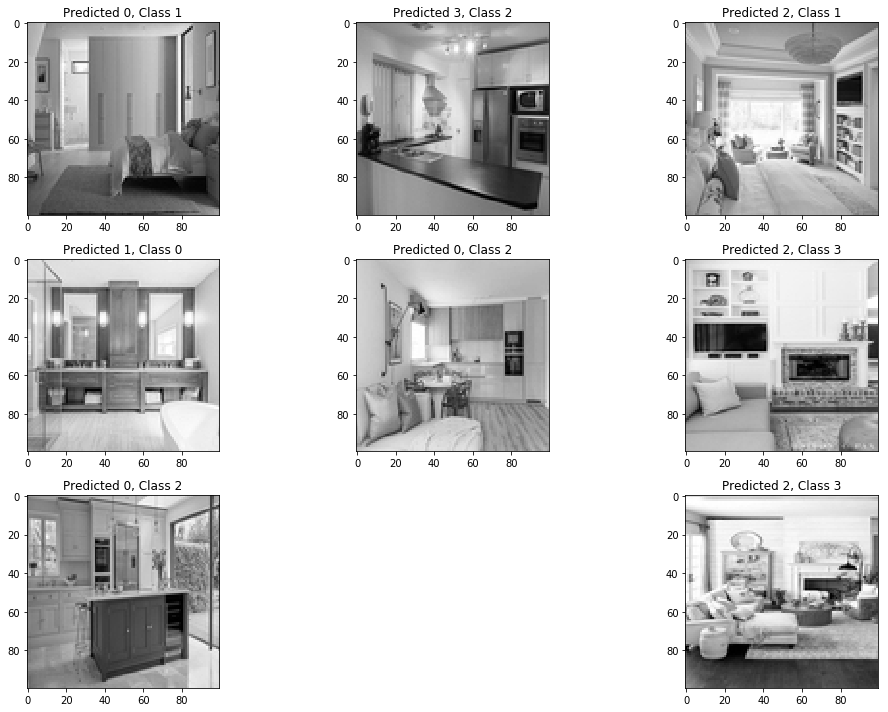

In [179]:
figure(figsize=(15, 10))
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
print("%f prcnt incorrect labels" % (len(incorrect) * 100 / len(test_Y)))
for i, incorrect in enumerate(random.sample(list(incorrect), 9)):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()